# Repeating pipelines
While looking into my Layered TPOT results, I noticed that the pipelines tested were not very diverse.
Specifically, not only would over time most of the population be duplicate pipelines, they would also be pipelines which have been evaluated in earlier generations.

Provided are the following three logs:

 * digits_10_50: digits dataset of sklearn with population size  10, 50 generations, seed = 42
 * phoneme_100_100_1: Texture dataset from PMLB with population size  100, 100 generations, seed = 1
 * phoneme_100_100_2: Texture dataset from PMLB with population size  100, 100 generations, seed = 2
 
I have many more available on request (mostly with default 100 pop, 100 gens, some terminated early due to time constraints).
The logs were obtained by recording at each generation each individual with their respective fitness (as well as how long it took to evaluate the whole generation), in the `eaMuPlusLambda` method.
 
Below I have plotted by generation the number of duplicates within a generation (not looking at previous generations) and the number of individuals in the generation that have been evaluated in an earlier generation, and thus could have been retrieved from the `evaluated_individuals` "cache".

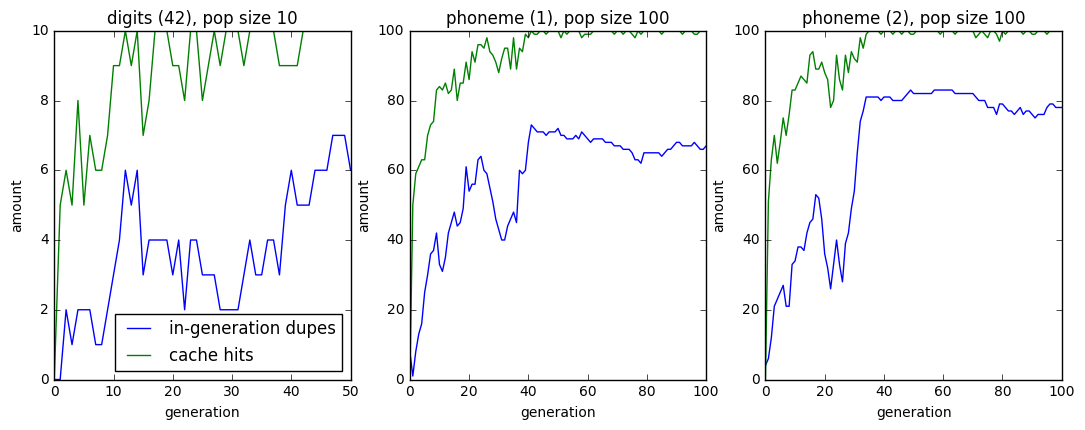

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import mpld3
import pickle

def dupes_in_pop(pop):
    dupes=0
    for i, (ind1, (ppl1, sc1)) in enumerate(pop):
        for ind2, (ppl2, sc2) in pop[i+1:]:
            if ind1 == ind2:
                dupes += 1
                break
    return dupes

mpld3.enable_notebook()

files = ['digits_10_50.pkl','phoneme_100_100_1.pkl','phoneme_100_100_2.pkl']
fig, axes = plt.subplots(ncols=3, figsize=(13,4.5))

for i, log_file in enumerate(files):
    with open(log_file,'rb') as fh:
        log = pickle.load(fh)

    seen_by_gen = [list(map(lambda x:x[0], log[0][1]))]
    for (gen, (dur, pop)) in list(log.items())[1:]:
        seen_this_gen = seen_by_gen[-1][:]
        for (ind,(pll,score)) in pop:
            if not ind in seen_this_gen:
                seen_this_gen.append(ind)
        seen_by_gen.append(seen_this_gen)

    dupes_per_gen = [dupes_in_pop(pop) for gen, (dur, pop) in log.items()]
    cache_per_gen = [sum([ind in seen_by_gen[gen-1] for ind, (pll, score) in pop])
                     for gen, (dur, pop) in log.items() if gen > 0]
    
    n_gens = len(log.keys())
    gens = range(n_gens)
    axes[i].plot(gens, dupes_per_gen, label='in-generation dupes')
    axes[i].plot(gens, [0] + cache_per_gen, label='cache hits')
    axes[i].set_xlabel('generation')
    axes[i].set_ylabel('amount')
    

axes[0].legend(loc=4)
axes[0].set_title('digits (42), pop size 10')
axes[1].set_title('phoneme (1), pop size 100')
axes[2].set_title('phoneme (2), pop size 100')

We can clearly see that in both cases both the amount of duplicates and number of cache hits rises.
First thing to note is that if a new individual appears multiple times in the same generation, these would not count as cache hits (but do count as duplicates).
This indicates that not only are there very few unique individuals per generation, they are often not new either.

Secondly, we see that very quickly the often almost the entire generation is cache hits, meaning few new pipelines are evaluated.
This is not due to a small configuration space (it's huge), but this is in particular highlighted since the digits log with a population of only 10 also quickly only gets cache hits.

I have yet to look into 